# Preprocessing the images

In [45]:
from PIL import Image

# Read the merge image
image_path = r"..\VTA\JW_NOSTIC_VTA10\JW_NOSTIC_VTA10_4-Region 004.tiff"
merge_image = Image.open(image_path)


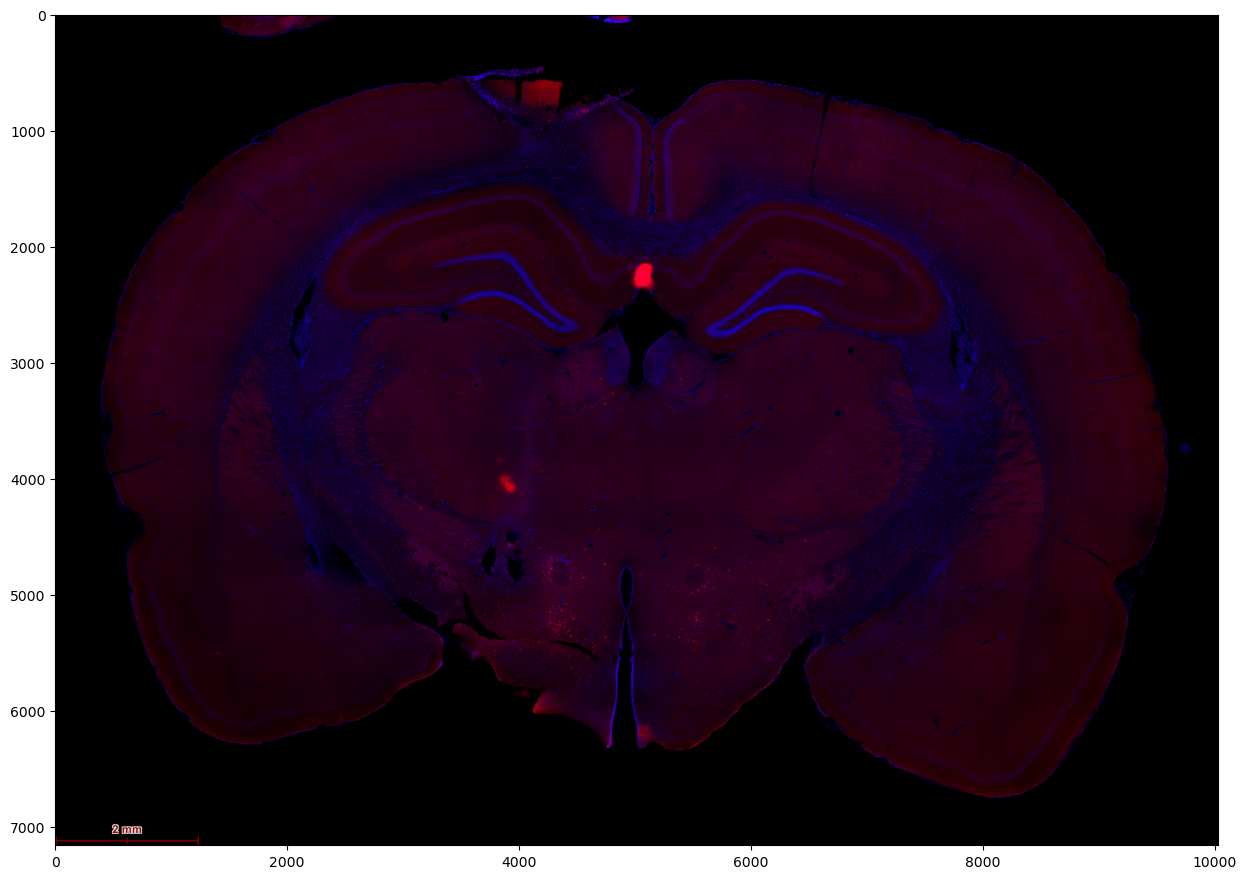

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15,15))
plt.imshow(merge_image)

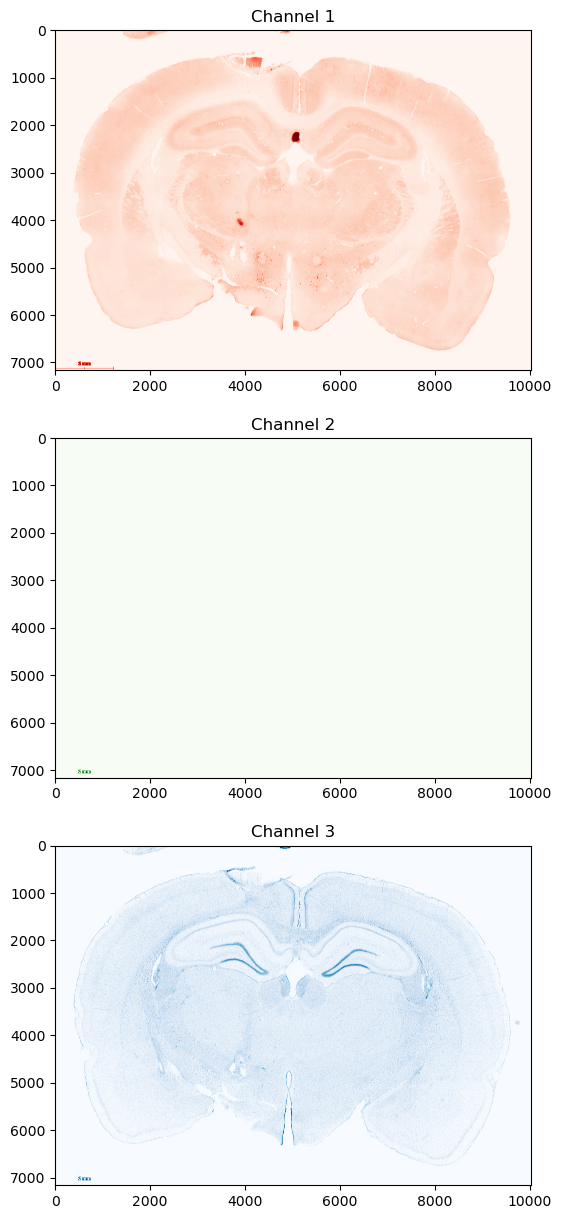

In [34]:
curImg = np.array(merge_image)
curImg.shape

# Plot each channel
plt.figure(figsize=(45,15))
plt.subplot(3,1,1)
plt.imshow(curImg[:,:,0], cmap='Reds')
plt.title('Channel 1')

plt.subplot(3,1,2)
plt.imshow(curImg[:,:,1], cmap='Greens')
plt.title('Channel 2')

plt.subplot(3,1,3)
plt.imshow(curImg[:,:,2], cmap='Blues')
plt.title('Channel 3')
plt.show()


In [37]:
from PIL import Image

# Read the merge image
image_path = r"D:\Histology_analysis\NOSTIC_VTA_NA_dataset\VTA\JW_NOSTIC_VTA10\JW_NOSTIC_VTA10_4-Region 004-channels.tiff"
channel_image = Image.open(image_path)

The image has 2 frames.
Frame 0 shape: (7160, 10024)


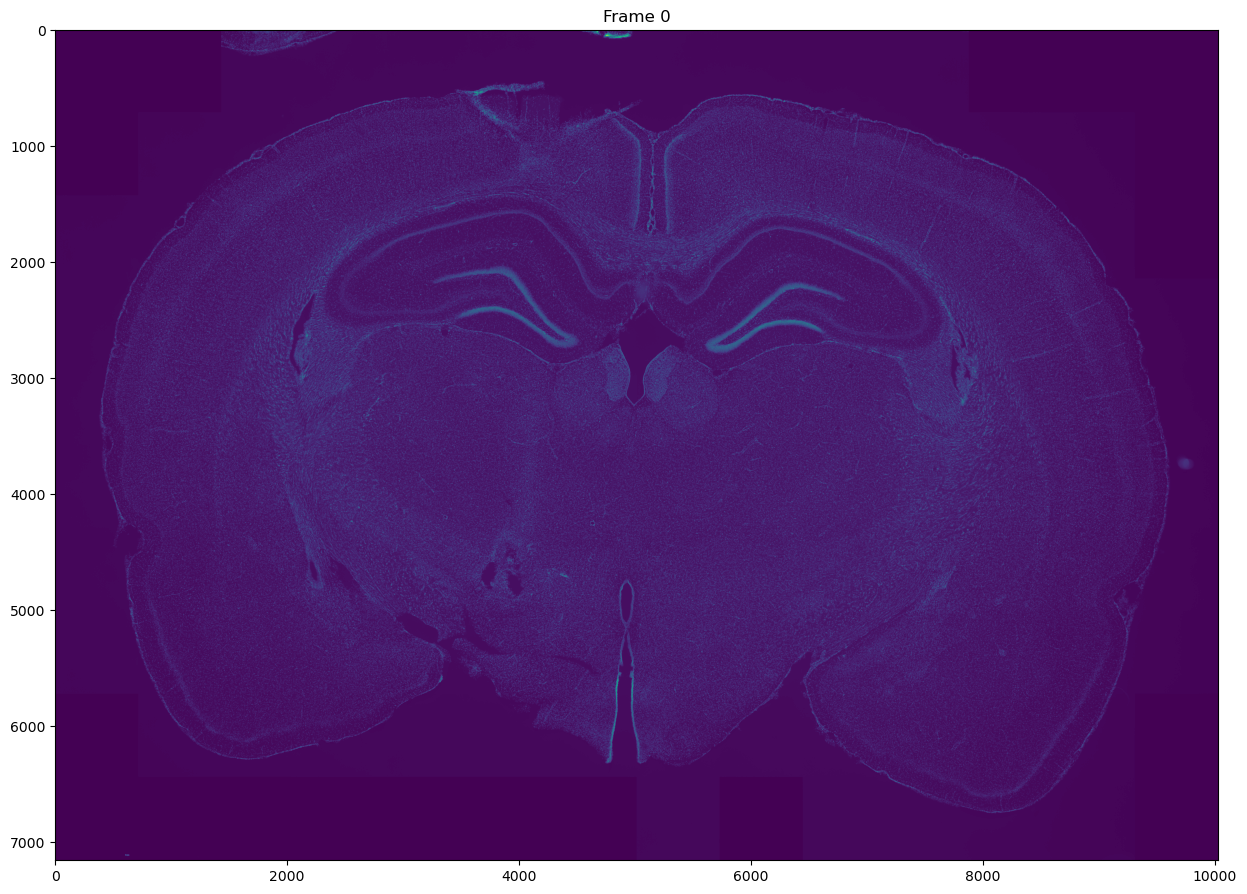

Frame 1 shape: (7160, 10024)


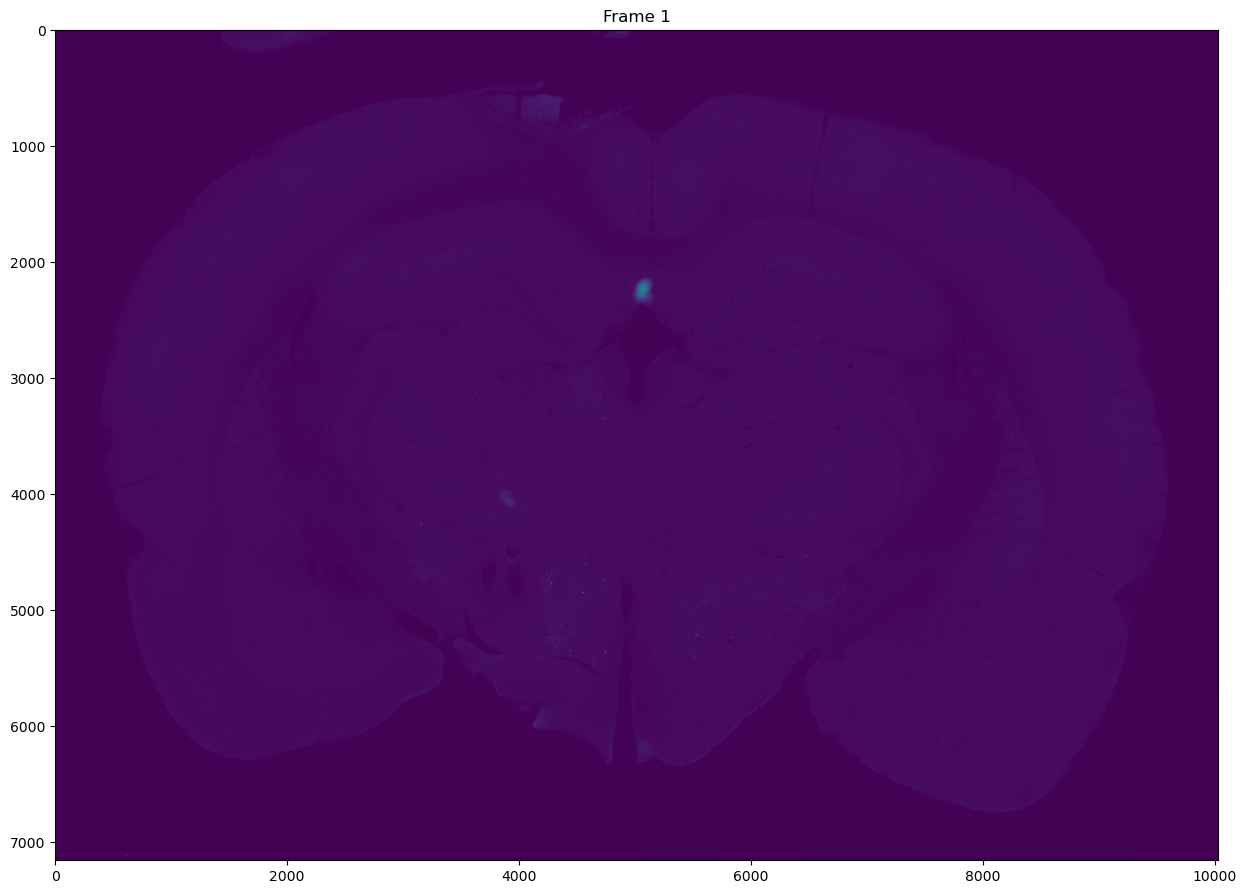

(7160, 10024, 3)


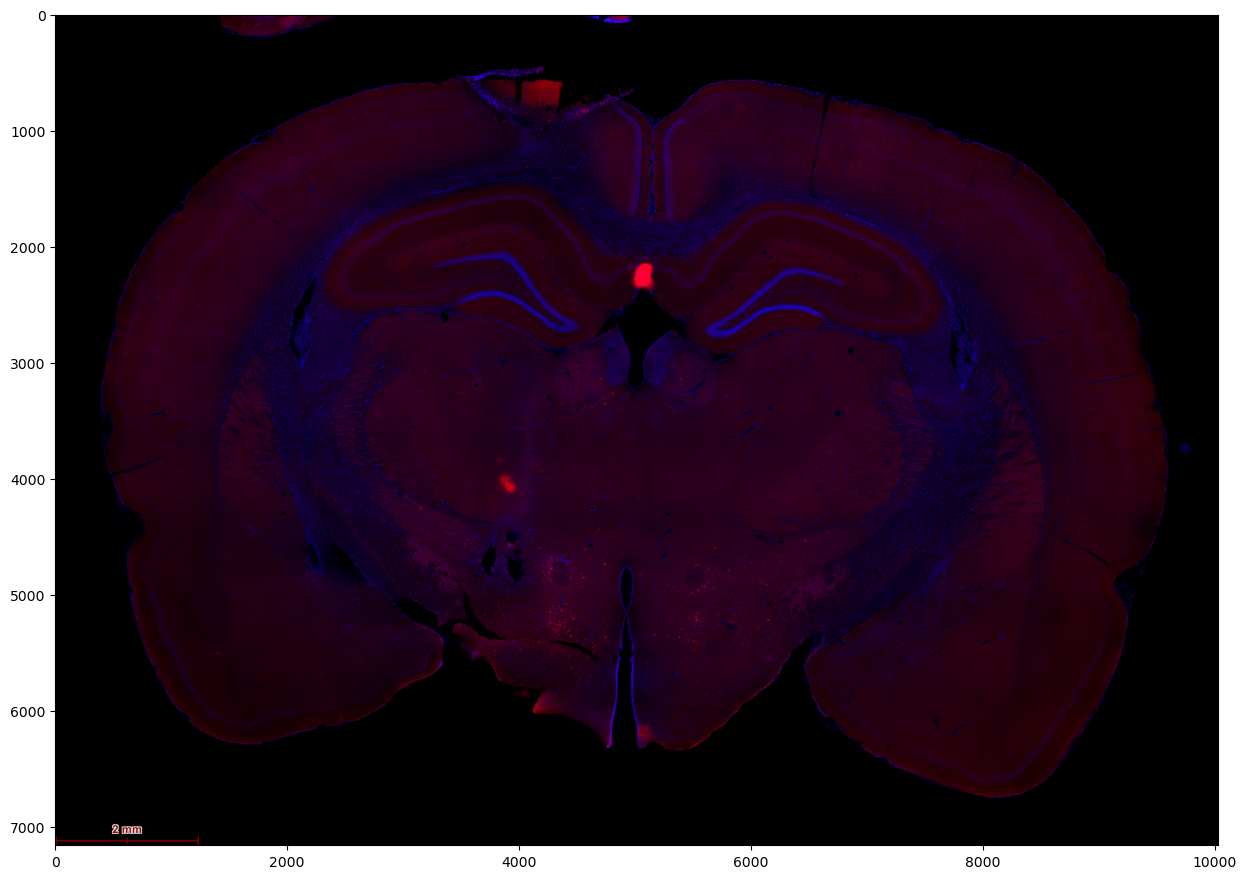

In [ ]:
nFrames = channel_image.n_frames
print(f'The image has {nFrames} frames.')
for i in range(nFrames):
    channel_image.seek(i)
    curImg = np.array(channel_image)
    print(f'Frame {i} shape: {curImg.shape}')
    plt.figure(figsize=(15,15))
    plt.imshow(curImg)
    plt.title(f'Frame {i}')
    plt.show()


**Take home message: channel data is better, the blue and red tend to mix together in the first and the third channels**

# Try one animal: Registration, Segmentation and cell-counting

In [1]:
subject_names = ["JW_NOSTIC2", 
                 "JW_NOSTIC3", 
                 "NOSTIC_VTA4", 
                 "NOSTIC_VTA_N6", 
                 "WT_VTA_N7", # channel
                 "NOSTIC_VTA_N8", 
                 "WT_VTA_N10", # channel
                 "NOSTIC_WT_N11", 
                 "JW_NOSTIC_VTA15", # channel
                 "JW_NOSTIC_VTA16", # channel
                ]

subject_NOT_USED = ["NOSTIC_VTA3", 
                    "JW_NOSTIC_VTA10",]

len(subject_names)

10

In [2]:
curSubject = subject_names[8]
print(f"Current subject: {curSubject}")

Current subject: JW_NOSTIC_VTA15


## Downsample the images

In [12]:
# Image enhancement functions for brightening dark images
import cv2
from skimage import exposure
import matplotlib.pyplot as plt

def gamma_correction(image, gamma=2.0):
    """
    Apply gamma correction to brighten dark images.
    gamma > 1.0 brightens the image (convex curve)
    gamma < 1.0 darkens the image (concave curve)
    """
    if isinstance(image, Image.Image):
        image_array = np.array(image)
    else:
        image_array = image
    
    # Normalize to 0-1 range
    normalized = image_array.astype(np.float32) / 255.0
    
    # Apply gamma correction (convex function for gamma > 1)
    corrected = np.power(normalized, 1.0 / gamma)
    
    # Convert back to 0-255 range
    result = (corrected * 255).astype(np.uint8)
    
    return result

def adaptive_histogram_equalization(image):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    for local contrast enhancement
    """
    if isinstance(image, Image.Image):
        image_array = np.array(image)
    else:
        image_array = image
    
    if len(image_array.shape) == 3:
        # Convert to grayscale for processing
        gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_array
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    return enhanced

def enhance_image_brightness(image, method='gamma', gamma=2.0, show_comparison=True):
    """
    Enhance image brightness using different methods
    
    Parameters:
    - image: PIL Image or numpy array
    - method: 'gamma', 'clahe', or 'both'
    - gamma: gamma value for correction (> 1.0 for brightening)
    - show_comparison: whether to display before/after comparison
    """
    if isinstance(image, Image.Image):
        original = np.array(image)
    else:
        original = image.copy()
    
    if method == 'gamma':
        enhanced = gamma_correction(original, gamma)
    elif method == 'clahe':
        enhanced = adaptive_histogram_equalization(original)
    elif method == 'both':
        # Apply gamma first, then CLAHE
        gamma_enhanced = gamma_correction(original, gamma)
        enhanced = adaptive_histogram_equalization(gamma_enhanced)
    else:
        raise ValueError("Method must be 'gamma', 'clahe', or 'both'")
    
    
    
    if show_comparison:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(original, cmap='gray' if len(original.shape) == 2 else None)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(enhanced, cmap='gray' if len(enhanced.shape) == 2 else None)
        plt.title(f'Enhanced ({method})')
        plt.axis('off')
        
        # Show histograms
        plt.subplot(1, 3, 3)
        if len(original.shape) == 2:
            plt.hist(original.flatten(), bins=50, alpha=0.7, label='Original', color='blue')
            plt.hist(enhanced.flatten(), bins=50, alpha=0.7, label='Enhanced', color='red')
        else:
            plt.hist(original.flatten(), bins=50, alpha=0.7, label='Original', color='blue')
            plt.hist(enhanced.flatten(), bins=50, alpha=0.7, label='Enhanced', color='red')
        plt.title('Histogram Comparison')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
    enhanced = Image.fromarray(enhanced) if isinstance(enhanced, np.ndarray) else enhanced
    return enhanced

# Test the enhancement on your current image
print("Testing image enhancement functions...")
print("Available methods: 'gamma' (convex curve), 'clahe' (adaptive), 'both' (combined)")

Testing image enhancement functions...
Available methods: 'gamma' (convex curve), 'clahe' (adaptive), 'both' (combined)


In [18]:
from PIL import Image, ImageOps
import numpy as np
import os
import glob

Image.MAX_IMAGE_PIXELS = 400000000  # or None to disable the check entirely

def _to_png_compatible(img: Image.Image, prefer_grayscale=True) -> Image.Image:
    # Normalize 16-bit or higher-depth images to 8-bit
    if img.mode in ("I;16", "I;16B", "I;16L", "I", "F"):
        arr = np.array(img)
        # robust normalization to 0..255
        a_min = float(arr.min())
        a_max = float(arr.max())
        if a_max > a_min:
            arr = (255.0 * (arr - a_min) / (a_max - a_min)).astype(np.uint8)
        else:
            arr = np.zeros_like(arr, dtype=np.uint8)
        return Image.fromarray(arr, mode="L")

    # Convert palette/CMYK/YCbCr to RGB
    if img.mode in ("P", "CMYK", "YCbCr"):
        img = img.convert("RGB")

    # Optionally force grayscale for DAPI
    if prefer_grayscale and img.mode == "RGB":
        img = ImageOps.grayscale(img)  # -> "L"
    elif img.mode == "RGBA":
        # drop alpha, then grayscale if preferred
        img = img.convert("RGB")
        if prefer_grayscale:
            img = ImageOps.grayscale(img)

    return img

def downsample_image_2Chnl(image_path, output_path, max_pixels=16000000*0.9):
    """
    Downsamples an image to ensure it is lower than the specified number of pixels.
    Saves as PNG for DeepSlice.
    """
    sliceName = os.path.basename(image_path)
    sliceName_png = os.path.splitext(sliceName)[0] + ".png"
    os.makedirs(output_path, exist_ok=True)  # ensure the target folder exists

    with Image.open(image_path) as img:
        # Use first frame if multi-frame (e.g., channels tiff)
        if getattr(img, "n_frames", 1) > 1:
            img.seek(1)

        # Make mode compatible with resize/save as PNG
        img = _to_png_compatible(img, prefer_grayscale=True)

        width, height = img.size
        total_pixels = width * height
        

        if total_pixels > max_pixels:
            scale = (max_pixels / total_pixels) ** 0.5
            new_size = (max(1, int(width * scale)), max(1, int(height * scale)))
            img = img.resize(new_size, Image.LANCZOS)
            img = enhance_image_brightness(img, method='both', gamma=2.0, show_comparison=False)
            print(f"Downsampled {image_path} to {new_size[0]}x{new_size[1]} pixels.")
        else:
            img = enhance_image_brightness(img, method='both', gamma=2.0, show_comparison=False)
            print(f"{image_path} is already below the maximum pixel limit.")

        img.save(os.path.join(output_path, sliceName_png))  # mode now PNG-safe

In [19]:
# ...existing code...
image_dir_raw = f"../VTA/{curSubject}/"
for image_path in glob.glob(os.path.join(image_dir_raw, "*.tiff")) \
                 + glob.glob(os.path.join(image_dir_raw, "*.tif")) \
                 + glob.glob(os.path.join(image_dir_raw, "*.png")):
    downsample_image_2Chnl(image_path, f"../Downsampled_mCherry/{curSubject}/")
# ...existing code...

C:\Users\Wenji\AppData\Local\Temp\ipykernel_8928\2447774054.py:19: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode="L")


Downsampled ../VTA/JW_NOSTIC_VTA15\JW_NOSTIC_VTA15_1-Region 1-channels.tiff to 4300x3348 pixels.
Downsampled ../VTA/JW_NOSTIC_VTA15\JW_NOSTIC_VTA15_1-Region 2-channels.tiff to 4536x3174 pixels.
Downsampled ../VTA/JW_NOSTIC_VTA15\JW_NOSTIC_VTA15_1-Region 3-channels.tiff to 4242x3394 pixels.
Downsampled ../VTA/JW_NOSTIC_VTA15\JW_NOSTIC_VTA15_1-Region 4-channels.tiff to 4449x3236 pixels.
Downsampled ../VTA/JW_NOSTIC_VTA15\JW_NOSTIC_VTA15_1-Region 5-channels.tiff to 4648x3097 pixels.
Downsampled ../VTA/JW_NOSTIC_VTA15\JW_NOSTIC_VTA15_1-Region 6-channels.tiff to 4449x3236 pixels.
Downsampled ../VTA/JW_NOSTIC_VTA15\JW_NOSTIC_VTA15_2-Region 001-channels.tiff to 4378x3289 pixels.
Downsampled ../VTA/JW_NOSTIC_VTA15\JW_NOSTIC_VTA15_2-Region 002-channels.tiff to 4383x3285 pixels.
Downsampled ../VTA/JW_NOSTIC_VTA15\JW_NOSTIC_VTA15_2-Region 003-channels.tiff to 4381x3286 pixels.
Downsampled ../VTA/JW_NOSTIC_VTA15\JW_NOSTIC_VTA15_2-Region 004-channels.tiff to 4380x3287 pixels.
Downsampled ../VTA/JW_

# Convert mCherry channel to PNG

In [18]:
import PIL.Image as Image
import numpy as np
import os, glob

def convert_mCherry_to_png(image_path, output_path):
    """
    Convert mCherry channel images to PNG format.
    """
    sliceName = os.path.basename(image_path)
    sliceName_png = os.path.splitext(sliceName)[0] + ".png"
    os.makedirs(output_path, exist_ok=True)  # ensure the target folder exists
    
    with Image.open(image_path) as img:
        # Use second frame if multi-frame (e.g., channels tiff)
        if getattr(img, "n_frames", 1) > 1:
            img.seek(1)
            
        # Convert to png
        png_img = _to_png_compatible(img, prefer_grayscale=True)
        # Save the mCherry channel as a PNG
        print(f"Saving mCherry channel for {sliceName} to {os.path.join(output_path, sliceName_png)}")
        png_img.save(os.path.join(output_path, sliceName_png))

In [19]:
# Convert mCherry channel images to PNG format.
image_dir_raw = f"../VTA/{curSubject}/"
for image_path in glob.glob(os.path.join(image_dir_raw, "*.tiff")) \
                 + glob.glob(os.path.join(image_dir_raw, "*.tif")) \
                 + glob.glob(os.path.join(image_dir_raw, "*.png")):
    convert_mCherry_to_png(image_path, f"../mCherry_PNG/{curSubject}/")

Saving mCherry channel for WT_VTA_N10_1-s001-channels.tiff to ../mCherry_PNG/WT_VTA_N10/WT_VTA_N10_1-s001-channels.png
Saving mCherry channel for WT_VTA_N10_1-s011-channels.tiff to ../mCherry_PNG/WT_VTA_N10/WT_VTA_N10_1-s011-channels.png
Saving mCherry channel for WT_VTA_N10_1-s021-channels.tiff to ../mCherry_PNG/WT_VTA_N10/WT_VTA_N10_1-s021-channels.png
Saving mCherry channel for WT_VTA_N10_1-s031-channels.tiff to ../mCherry_PNG/WT_VTA_N10/WT_VTA_N10_1-s031-channels.png
Saving mCherry channel for WT_VTA_N10_1-s041-channels.tiff to ../mCherry_PNG/WT_VTA_N10/WT_VTA_N10_1-s041-channels.png
Saving mCherry channel for WT_VTA_N10_2-s051-channels.tiff to ../mCherry_PNG/WT_VTA_N10/WT_VTA_N10_2-s051-channels.png
Saving mCherry channel for WT_VTA_N10_2-s061-channels.tiff to ../mCherry_PNG/WT_VTA_N10/WT_VTA_N10_2-s061-channels.png
Saving mCherry channel for WT_VTA_N10_2-s071-channels.tiff to ../mCherry_PNG/WT_VTA_N10/WT_VTA_N10_2-s071-channels.png
Saving mCherry channel for WT_VTA_N10_2-s081-cha

In [ ]:
# Test enhancement on one of your images
test_image_path = f"../VTA/{curSubject}/"
test_files = glob.glob(os.path.join(test_image_path, "*.tiff")) + glob.glob(os.path.join(test_image_path, "*.tif"))

if test_files:
    # Load the first image for testing
    with Image.open(test_files[0]) as img:
        if getattr(img, "n_frames", 1) > 1:
            img.seek(1)  # Use mCherry channel
        test_img = np.array(img)
    
    print(f"Testing enhancement on: {os.path.basename(test_files[0])}")
    print(f"Image shape: {test_img.shape}")
    print(f"Pixel value range: {test_img.min()} - {test_img.max()}")
    
    # Try different gamma values
    for gamma_val in [1.5, 2.0, 2.5]:
        print(f"\n=== Gamma correction with γ = {gamma_val} ===")
        enhanced = enhance_image_brightness(test_img, method='gamma', gamma=gamma_val, show_comparison=True)
else:
    print("No TIFF files found for testing. Make sure your data path is correct.")

In [ ]:
# Enhanced downsampling function with brightness correction
def downsample_image_enhanced(image_path, output_path, max_pixels=16000000*0.9, 
                             enhance_brightness=True, gamma=2.0, method='gamma'):
    """
    Downsamples an image with optional brightness enhancement.
    Saves as PNG for DeepSlice.
    """
    sliceName = os.path.basename(image_path)
    sliceName_png = os.path.splitext(sliceName)[0] + ".png"
    os.makedirs(output_path, exist_ok=True)

    with Image.open(image_path) as img:
        # Use first frame if multi-frame (e.g., channels tiff)
        if getattr(img, "n_frames", 1) > 1:
            img.seek(1)  # Use mCherry channel (frame 1)

        # Make mode compatible with resize/save as PNG
        img = _to_png_compatible(img, prefer_grayscale=True)
        img_array = np.array(img)
        
        # Apply brightness enhancement if requested
        if enhance_brightness:
            print(f"Enhancing brightness with {method} (γ={gamma})...")
            img_array = enhance_image_brightness(img_array, method=method, gamma=gamma, show_comparison=False)
        
        # Convert back to PIL Image
        enhanced_img = Image.fromarray(img_array, mode='L')
        
        width, height = enhanced_img.size
        total_pixels = width * height

        if total_pixels > max_pixels:
            scale = (max_pixels / total_pixels) ** 0.5
            new_size = (max(1, int(width * scale)), max(1, int(height * scale)))
            enhanced_img = enhanced_img.resize(new_size, Image.LANCZOS)
            print(f"Downsampled {image_path} to {new_size[0]}x{new_size[1]} pixels.")
        else:
            print(f"{image_path} is already below the maximum pixel limit.")

        enhanced_img.save(os.path.join(output_path, sliceName_png))
        print(f"Saved enhanced image: {sliceName_png}")

# Process all images with enhancement
print(f"Processing {curSubject} with brightness enhancement...")
image_dir_raw = f"../VTA/{curSubject}/"
enhanced_output_dir = f"../Downsampled_Enhanced/{curSubject}/"

for image_path in glob.glob(os.path.join(image_dir_raw, "*.tiff")) + glob.glob(os.path.join(image_dir_raw, "*.tif")):
    downsample_image_enhanced(image_path, enhanced_output_dir, 
                             enhance_brightness=True, gamma=2.0, method='gamma')

# High pass filtering all the raw png images

# Resgister the slices to atlas using DeepSlice

In [20]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [21]:
# ...existing code...
# filepath: d:\Histology_analysis\NOSTIC_VTA_NA_dataset\Scripts\Histology_To_atlas_test.ipynb
# Define the folder with your PNGs

import os
folderpath = f"../Downsampled_mCherry/{curSubject}/"

from DeepSlice import DSModel
Model = DSModel('rat')
Model.predict(folderpath, ensemble=True, section_numbers=False)
Model.propagate_angles()
Model.save_predictions(os.path.join(folderpath, "MyResults"))



Found 30 validated image filenames.
30/30 [==============================] - 5s 158ms/step
DV angle: -0.45475335176132065
ML angle: 0.7542283825680264
DV angle: -0.4545042130643807
ML angle: 0.7542285577019398
30
saving to ../Downsampled_mCherry/JW_NOSTIC_VTA15/MyResults.json


In [ ]:
# pip install DeepSlice

from DeepSlice import DSModel
species = 'rat' #available species are 'mouse' and 'rat'

Model = DSModel(species)

In [ ]:
Model.predict(folderpath, ensemble=True, section_numbers=False) 

Found 18 validated image filenames.
18/18 [==============================] - 5s 283ms/step


In [1]:
Model.propagate_angles()  

NameError: name 'Model' is not defined

In [ ]:
Model.predictions

Filenames          ox          oy  \
0               toyota_slide2_04_stitched.png  461.959704  490.276009   
1               toyota_slide2_02_stitched.png  472.654811  492.109673   
2   Experiment-7982-Shading Correction-32.png  461.227257  502.895189   
3                            TOyota_02_c2.png  486.005517  513.313907   
4   Experiment-7985-Shading Correction-38.png  455.527791  535.308592   
5                        TOyota_01_lzw_c2.png  475.006163  530.193786   
6               toyota_slide2_01_stitched.png  462.639292  531.234751   
7               toyota_slide3_04_stitched.png  461.019937  550.222444   
8               toyota_slide2_03_stitched.png  461.600938  542.109204   
9   Experiment-7984-Shading Correction-36.png  456.129918  554.067757   
10  Experiment-7983-Shading Correction-34.png  451.450143  554.066695   
11              toyota_slide3_05_stitched.png  452.295455  576.337559   
12  Experiment-7986-Shading Correction-40.png  423.063091  603.141793   
13              toyota_slide3_06_stitched.png  434.584618  614.013662   
14              toyota_slide3_01_stitched.png  422.961342  656.113387   
15              toyota_slide3_02_stitched.png  429.866795  654.221484   
16              toyota_slide3_03_stitched.png  422.339965  681.557179   
17  Experiment-7987-Shading Correction-42.png  408.485873  726.563986   

            oz          ux         uy         uz         vx        vy  \
0   439.110005 -419.179312 -12.717386  23.087787 -13.593273  3.358491   
1   435.970061 -430.734503 -13.276782  39.105269 -28.136818  3.238996   
2   438.553191 -438.538440 -13.278628  22.232359 -14.001835  3.547182   
3   431.201961 -471.197870 -14.105521  11.955215  -7.996285  3.823610   
4   447.586019 -419.075952 -12.438280   2.755496  -2.499054  4.049026   
5   448.222580 -447.204042 -13.246903   1.008822  -1.090946  4.305905   
6   450.827703 -432.658236 -12.843464   2.996472  -2.999424  4.207142   
7   441.632936 -426.308367 -12.779225  12.104618  -9.768999  3.913449   
8   449.423239 -426.673648 -12.638114   0.914947  -1.758478  4.204901   
9   427.037922 -401.997818 -12.191372  21.791709 -15.454303  3.628581   
10  439.803430 -416.191714 -12.168452 -10.832362   6.790052  4.246597   
11  453.623069 -414.004286 -12.226228  -1.809299   0.310999  4.127770   
12  437.600423 -373.278168 -11.282868  17.471039 -10.952880  3.350686   
13  431.540015 -388.939810 -11.664479  11.443622  -6.163907  3.611408   
14  432.062410 -360.852692 -10.692193   1.046460   1.717796  3.561575   
15  444.901622 -390.427375 -11.455258  -7.208732   7.640595  4.043558   
16  426.531544 -350.808650 -10.584633  15.015349  -9.547888  3.133480   
17  421.724746 -342.167185 -10.149541   1.802962  -0.279837  3.321151   

            vz  width  height  
0  -276.996275   4815    2990  
1  -299.892816   4711    3056  
2  -291.784782   4730    3044  
3  -299.056091   4761    3023  
4  -303.677375   4560    3157  
5  -319.529101   4561    3157  
6  -316.414353   4626    3112  
7  -309.536556   4500    3199  
8  -313.544601   4501    3199  
9  -300.945983   4544    3168  
10 -297.983801   4559    3157  
11 -303.352767   4499    3200  
12 -270.666567   4546    3167  
13 -279.432370   4503    3197  
14 -258.583198   4571    3149  
15 -281.174925   4530    3178  
16 -251.605760   4510    3192  
17 -245.228990   4638    3104

In [ ]:
Model.save_predictions(folderpath + 'MyResults')      

18
saving to /mnt/c/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/toyota/clean/MyResults.json


## Environment check (run after selecting the Python 3.9 env)

After creating and selecting the new kernel, run the next cell to verify TensorFlow and DeepSlice are installed and working.

In [ ]:
# Verify TF and DeepSlice in the selected environment
import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

import tensorflow as tf
print("TensorFlow:", tf.__version__)

try:
    from DeepSlice import DSModel
    m = DSModel('rat')
    print("DeepSlice loaded.")
except Exception as e:
    print("DeepSlice import failed:", e)

# Read H5 files

In [1]:
import h5py

h5_file_path = "D:/Histology_analysis/NOSTIC_VTA_NA_dataset/mCherry_PNG/JW_NOSTIC_VTA15/JW_NOSTIC_VTA15_4-Region 001-channels_Simple Segmentation.h5"
with h5py.File(h5_file_path, "r") as f:
    # Explore the structure of the HDF5 file
    print("Keys in the HDF5 file:")
    for key in f.keys():
        print(f" - {key}")

Keys in the HDF5 file:
 - exported_data


In [2]:
with h5py.File(h5_file_path, "r") as f:
    # read 
    data = f['exported_data'][:]
    attrs = dict(f.attrs)
    print(f.keys())

<KeysViewHDF5 ['exported_data']>


In [3]:
import numpy as np
np.shape(data)

(6444, 9308, 1)

In [4]:
np.unique(data)

array([1, 2], dtype=uint8)

In [5]:
print(np.sum(data==0))
print(np.sum(data==1))
print(np.sum(data==2))

0
27692
59953060


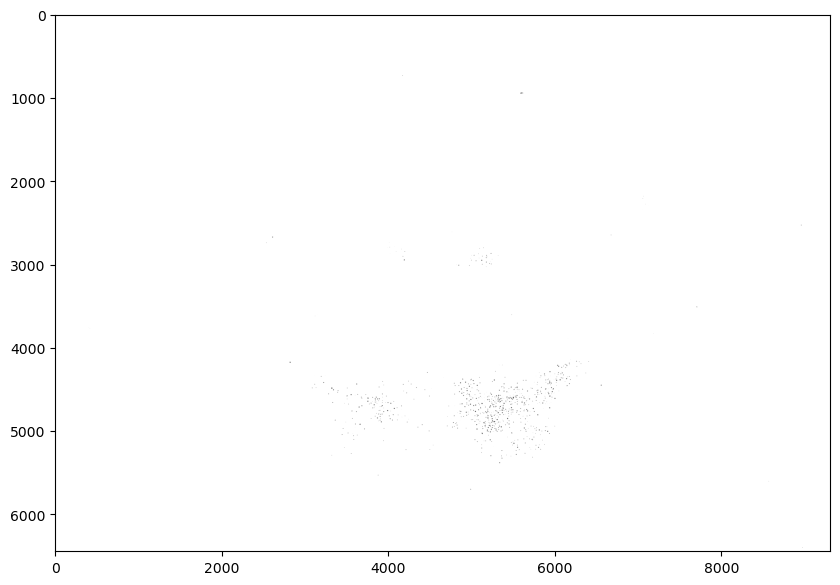

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(data, cmap='gray')
# plt.xlim(5000,6000)
# plt.ylim(4000, 5000)

In [15]:
from scipy import ndimage

labeled_array, num_neurons = ndimage.label(data01)
print(f"Number of neurons: {num_neurons}")

Number of neurons: 970


In [13]:
data01 = (data == 1).astype(np.uint8)

In [14]:
data01.shape

(6444, 9308, 1)

In [23]:
import numpy as np
from scipy import ndimage
from skimage import measure
from skimage.morphology import remove_small_objects

# # Load segmentation map
# seg_map = np.load('your_segmentation.npy')

# Method 1: Using scipy.ndimage
data01 = (data == 1).astype(np.uint8)
data01_2d = np.squeeze(data01)  # Ensure it's 2D if needed
labeled_array, num_neurons = ndimage.label(data01)
print(f"Number of neurons: {num_neurons}")
# Filter out small objects (noise) by setting minimum area using skimage
min_area = 10

# Option 1: Use remove_small_objects (recommended)
data01_filtered = remove_small_objects(data01_2d.astype(bool), min_size=min_area)
labeled_array, num_neurons = ndimage.label(data01_filtered.astype(np.uint8))
print(f"Number of neurons (min {min_area} pixels): {num_neurons}")

# Method 2: Using skimage (more options)
labeled_array = measure.label(data01_filtered, connectivity=2)  # 2D: connectivity=2, 3D: connectivity=3
num_neurons = labeled_array.max()
print(f"Number of neurons: {num_neurons}")

# Get properties of each neuron region
props = measure.regionprops(labeled_array)
for i, prop in enumerate(props):
    print(f"Neuron {i+1}: Area = {prop.area} pixels, Centroid = {prop.centroid}")

Number of neurons: 970
Number of neurons (min 10 pixels): 617
Number of neurons: 616
Neuron 1: Area = 21.0 pixels, Centroid = (738.047619047619, 4174.238095238095)
Neuron 2: Area = 139.0 pixels, Centroid = (948.2877697841726, 5598.330935251798)
Neuron 3: Area = 57.0 pixels, Centroid = (947.6666666666666, 5616.771929824561)
Neuron 4: Area = 11.0 pixels, Centroid = (2213.3636363636365, 7059.545454545455)
Neuron 5: Area = 34.0 pixels, Centroid = (2532.676470588235, 8962.64705882353)
Neuron 6: Area = 21.0 pixels, Centroid = (2651.4285714285716, 6678.333333333333)
Neuron 7: Area = 67.0 pixels, Centroid = (2676.373134328358, 2613.223880597015)
Neuron 8: Area = 16.0 pixels, Centroid = (2744.375, 2538.5625)
Neuron 9: Area = 12.0 pixels, Centroid = (2797.5833333333335, 4020.25)
Neuron 10: Area = 18.0 pixels, Centroid = (2804.722222222222, 5146.388888888889)
Neuron 11: Area = 16.0 pixels, Centroid = (2812.6875, 5099.0625)
Neuron 12: Area = 24.0 pixels, Centroid = (2850.0833333333335, 4201.083333

In [21]:
# Make both methods use the same connectivity
import numpy as np
from scipy import ndimage
from skimage import measure

data01 = (data == 1).astype(np.uint8)

# Method 1: Force 8-connectivity in scipy
structure = np.ones((3,3), dtype=int)  # 8-connectivity
data01_2d = np.squeeze(data01)  # Ensure it's 2D if needed
labeled_array1, num_neurons1 = ndimage.label(data01_2d, structure=structure)
print(f"Method 1 (8-connectivity): {num_neurons1} neurons")

# Method 2: Use 8-connectivity (same as above)
labeled_array2 = measure.label(data01_2d, connectivity=2)
num_neurons2 = labeled_array2.max()
print(f"Method 2 (8-connectivity): {num_neurons2} neurons")

# OR: Force both to use 4-connectivity
labeled_array3 = measure.label(data01_2d, connectivity=1)  # 4-connectivity
num_neurons3 = labeled_array3.max()
print(f"Method 2 (4-connectivity): {num_neurons3} neurons")

# Default scipy (4-connectivity)
labeled_array4, num_neurons4 = ndimage.label(data01_2d)  # default 4-connectivity
print(f"Method 1 (4-connectivity): {num_neurons4} neurons")

Method 1 (8-connectivity): 879 neurons
Method 2 (8-connectivity): 879 neurons
Method 2 (4-connectivity): 970 neurons
Method 1 (4-connectivity): 970 neurons


In [24]:
np.array([1,2,3]) / np.array([4,5,6])

array([0.25, 0.4 , 0.5 ])

# Input registration results

In [1]:
def downsample_atlas_to_epi_resolution(atlas_39um, target_voxel_size_mm=[0.5, 0.5, 1.0]):
    """
    Downsample 39μm atlas to EPI resolution using majority voting for ROI preservation
    """
    current_voxel_size_um = [39, 39, 39]
    target_voxel_size_um = [size * 1000 for size in target_voxel_size_mm]  # Convert to μm
    
    # Calculate downsampling factors
    downsample_factors = [target / current for target, current in 
                         zip(target_voxel_size_um, current_voxel_size_um)]
    
    print(f"Downsampling factors: {downsample_factors}")  # [12.8, 12.8, 25.6]
    
    # Use block_reduce with majority voting to preserve ROI labels
    from skimage.measure import block_reduce
    
    downsampled_atlas = block_reduce(atlas_39um, 
                                   block_size=tuple(map(int, downsample_factors)),
                                   func=lambda block: np.bincount(block.flatten()).argmax())
    
    return downsampled_atlas

# Load the atlas

In [1]:
import nibabel as nib
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
atlas_path = "D:/Histology_analysis/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_atlas_v4.nii"
# atlas_path = "D:/Histology_analysis/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_T2star_v1.01.nii"
# atlas_path = "/home/jifenge/Jasanoff_Lab/Rat_atlas/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_FA_color_v1.01.nii"
# atlas_path = "/home/jifenge/Jasanoff_Lab/Rat_atlas/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_T2star_v1.01.nii"
atlas_data = nib.load(atlas_path).get_fdata()
print(atlas_data.shape)

(512, 1024, 512)


In [2]:
target_voxel_size_mm = [0.1, 0.5, 0.1]

current_voxel_size_um = [39, 39, 39]
target_voxel_size_um = [size * 1000 for size in target_voxel_size_mm]  # Convert to μm
downsample_factors = [target / current for target, current in zip(target_voxel_size_um, current_voxel_size_um)]
print(downsample_factors)

[2.5641025641025643, 12.820512820512821, 2.5641025641025643]


In [3]:
from scipy.ndimage import zoom


# You're right, block_reduce with complex functions can be problematic for 3D arrays
# Let's try a different approach for downsampling the atlas

def downsample_atlas_simple(atlas_3d, downsample_factors):
    """
    Simple downsampling using nearest neighbor interpolation
    """
    zoom_factors = [1.0 / factor for factor in downsample_factors]
    return zoom(atlas_3d, zoom_factors, order=0)  # order=0 for nearest neighbor

# Alternative: Manual block downsampling for better control
def downsample_atlas_manual(atlas_3d, block_size):
    """
    Manual block downsampling with majority voting
    """
    h, w, d = atlas_3d.shape
    bh, bw, bd = block_size
    
    new_h, new_w, new_d = h//bh, w//bw, d//bd
    downsampled = np.zeros((new_h, new_w, new_d), dtype=atlas_3d.dtype)
    
    for i in range(new_h):
        for j in range(new_w):
            for k in range(new_d):
                block = atlas_3d[i*bh:(i+1)*bh, j*bw:(j+1)*bw, k*bd:(k+1)*bd]
                unique_vals, counts = np.unique(block, return_counts=True)
                downsampled[i, j, k] = unique_vals[np.argmax(counts)]
    
    return downsampled

print("Consider using scipy.ndimage.zoom or manual block downsampling instead")

Consider using scipy.ndimage.zoom or manual block downsampling instead


In [4]:
# simple way
downsampled_atlas = downsample_atlas_simple(atlas_data, downsample_factors=downsample_factors)
print(f"Original atlas shape: {atlas_data.shape}")
print(f"Downsampled atlas shape: {downsampled_atlas.shape}")
print(f"Downsample factors {downsample_factors}")

Original atlas shape: (512, 1024, 512)
Downsampled atlas shape: (200, 80, 200)
Downsample factors [2.5641025641025643, 12.820512820512821, 2.5641025641025643]


In [5]:
def save_atlas_as_nifti(atlas_array, output_path, voxel_size_mm=[0.5, 1.0, 0.5]):
    """
    Save atlas array as NIfTI file (skip AFNI conversion)
    """
    import nibabel as nib
    
    # Convert to appropriate data type
    atlas_int = atlas_array.astype(np.int16)
    
    # Create affine matrix with proper voxel spacing
    affine = np.eye(4)
    affine[0, 0] = voxel_size_mm[0]  # x spacing
    affine[1, 1] = voxel_size_mm[1]  # y spacing  
    affine[2, 2] = voxel_size_mm[2]  # z spacing
    
    # Create and save NIfTI image
    nii_img = nib.Nifti1Image(atlas_int, affine)
    nib.save(nii_img, output_path)
    
    print(f"Successfully saved atlas as NIfTI: {output_path}")
    return output_path

# Use this instead
output_path = "atlas_label_0105.nii.gz"
save_atlas_as_nifti(downsampled_atlas, output_path, target_voxel_size_mm)

Successfully saved atlas as NIfTI: atlas_label_0105.nii.gz


'atlas_label_0105.nii.gz'

In [57]:
target_voxel_size_mm

[0.1, 0.5, 0.1]

In [20]:
def save_atlas_as_brik(atlas_array, output_prefix, voxel_size_mm=[0.5, 1.0, 0.5]):
    """
    Save atlas array as AFNI BRIK/HEAD file pair using WSL
    """
    import subprocess
    import os
    import nibabel as nib
    
    # Convert to appropriate data type for AFNI
    atlas_int = atlas_array.astype(np.int16)

    temp_nii_path = "D:/Histology_analysis/NOSTIC_VTA_NA_dataset/Scripts/downsampled_rat_atlas3.nii.gz"
    try:
        # Create affine matrix with proper voxel spacing
        affine = np.eye(4)
        affine[0, 0] = voxel_size_mm[0]  # x spacing
        affine[1, 1] = voxel_size_mm[1]  # y spacing  
        affine[2, 2] = voxel_size_mm[2]  # z spacing
        
        # Create NIfTI image
        nii_img = nib.Nifti1Image(atlas_int, affine)
        nib.save(nii_img, temp_nii_path)
        
        # Convert Windows path to WSL path
        wsl_temp_path = temp_nii_path.replace('\\', '/').replace('D:', '/mnt/d')
        wsl_output_prefix = output_prefix.replace('\\', '/').replace('D:', '/mnt/d')
        
        # Convert NIfTI to BRIK using AFNI's 3dcopy through WSL
        cmd = f"wsl 3dcopy {wsl_temp_path} {wsl_output_prefix}"
        
        print(f"Converting to BRIK format via WSL: {cmd}")
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
        
        if result.returncode == 0:
            print(f"Successfully created {output_prefix}+orig.BRIK and {output_prefix}+orig.HEAD")
        else:
            print(f"Error: {result.stderr}")
            print(f"Stdout: {result.stdout}")
            
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        # Clean up temporary file (uncommented for proper cleanup)
        if os.path.exists(temp_nii_path):
            try:
                os.unlink(temp_nii_path)
                print(f"Cleaned up temporary file: {temp_nii_path}")
            except Exception as e:
                print(f"Warning: Could not clean up temporary file {temp_nii_path}: {e}")

In [15]:
output_path = "downsampled_rat_atlas"
save_atlas_as_brik(downsampled_atlas, output_path, target_voxel_size_mm)

Converting to BRIK format via WSL: wsl 3dcopy /mnt/d/Histology_analysis/NOSTIC_VTA_NA_dataset/Scripts/downsampled_rat_atlas3.nii.gz downsampled_rat_atlas
Error: 


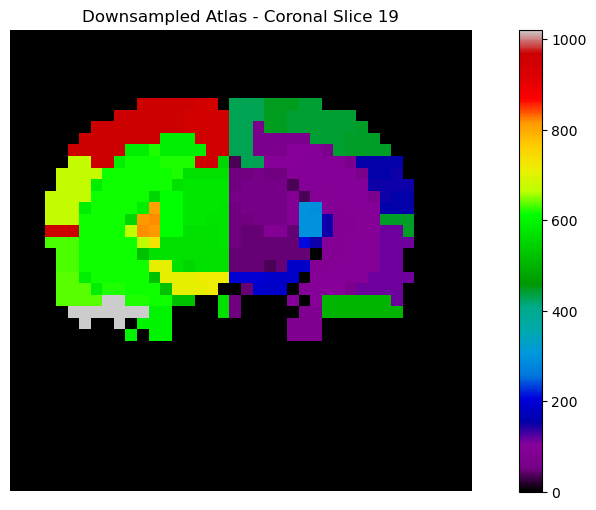

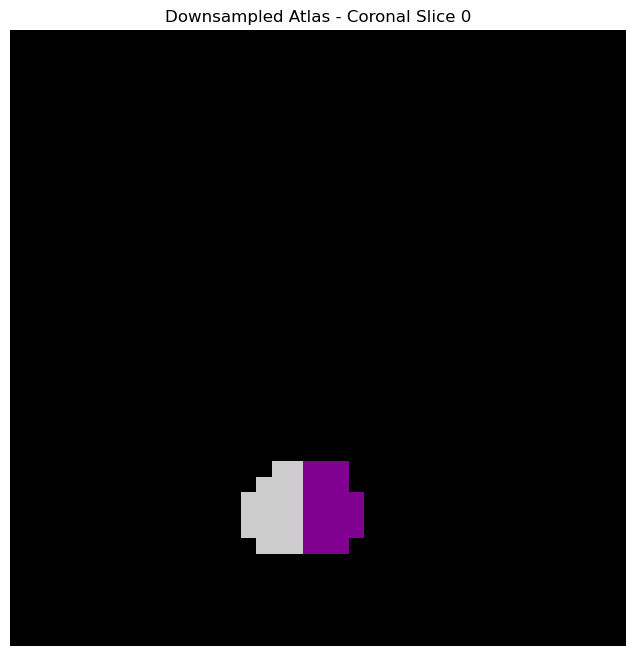

In [73]:
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(np.rot90(downsampled_atlas[:, 19, :]), cmap='nipy_spectral')

plt.title('Downsampled Atlas - Coronal Slice 19')
plt.colorbar()
plt.axis('off')
plt.show()

# Create a video sliding through all coronal slices
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

def animate(frame):
    ax.clear()
    ax.imshow(np.rot90(downsampled_atlas[:, frame, :]), cmap='nipy_spectral')
    ax.set_title(f'Downsampled Atlas - Coronal Slice {frame}')
    ax.axis('off')

# Create animation through all slices in the second dimension
anim = FuncAnimation(fig, animate, frames=downsampled_atlas.shape[1], interval=200, repeat=True)
# plt.show()

# To save as video file (optional):
anim.save('atlas_coronal_slices.mp4', writer='ffmpeg', fps=5)

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def extract_section(atlas_data, origin, u_vector, v_vector, output_size=None):
    """
    Extract a 2D section from a 3D atlas using nearest neighbor sampling.
    
    Parameters:
    -----------
    atlas_data : numpy.ndarray
        3D atlas volume (can be a regular array or memory-mapped array)
    origin : numpy.ndarray or list
        Origin vector (O) - coordinates of the top-left corner of the section
    u_vector : numpy.ndarray or list
        U vector - vector from origin to top-right corner
    v_vector : numpy.ndarray or list
        V vector - vector from origin to bottom-left corner
    output_size : tuple or None
        Target size of the output section (width, height)
        If None, dimensions will be calculated from vector magnitudes
    
    Returns:
    --------
    section_image : numpy.ndarray
        2D image representing the extracted section
    """
    # Convert inputs to numpy arrays if they aren't already
    origin = np.array(origin)
    u_vector = np.array(u_vector)
    v_vector = np.array(v_vector)
    
    # If output_size not provided, use the magnitudes of the vectors
    if output_size is None:
        u_length = np.linalg.norm(u_vector)
        v_length = np.linalg.norm(v_vector)
        
        width = int(u_length)
        height = int(v_length)
        output_size = (width, height)
        # # Keep the aspect ratio, but limit maximum size to 1024 pixels
        # max_dim = 1024
        # scale = min(max_dim / u_length, max_dim / v_length)
        # width = max(int(u_length * scale), 1)
        # height = max(int(v_length * scale), 1)
        # output_size = (width, height)
    
    width, height = output_size
    
    # Create output image array
    section_image = np.zeros((height, width), dtype=atlas_data.dtype)
    
    # For each pixel in the output image, find the nearest voxel in the atlas
    for y in range(height):
        for x in range(width):
            # Calculate normalized coordinates within the section
            x_norm = x / (width - 1) if width > 1 else 0.5
            y_norm = y / (height - 1) if height > 1 else 0.5
            
            # Calculate the corresponding 3D position in atlas space
            # This is a weighted sum of the three vectors
            pos = origin + x_norm * u_vector + y_norm * v_vector
            
            # Round to nearest voxel coordinates (nearest neighbor sampling)
            x_atlas = int(round(pos[0]))
            y_atlas = int(round(pos[1]))
            z_atlas = int(round(pos[2]))
            
            # Ensure coordinates are within atlas bounds
            x_atlas = max(0, min(x_atlas, atlas_data.shape[0] - 1))
            y_atlas = max(0, min(y_atlas, atlas_data.shape[1] - 1))
            z_atlas = max(0, min(z_atlas, atlas_data.shape[2] - 1))
            
            # Sample the atlas at the nearest voxel
            section_image[y, x] = atlas_data[x_atlas, y_atlas, z_atlas]
    
    return section_image


import numpy as np
from skimage import transform

def upsample_and_pad_atlas_slice(atlas_slice, target_dims):
    """
    Upsample the atlas slice to match the target dimensions and apply symmetric zero-padding.
    
    Parameters:
    -----------
    atlas_slice : numpy.ndarray
        2D atlas slice array
    target_dims : tuple
        Target dimensions (height, width)
    
    Returns:
    --------
    padded_data : numpy.ndarray
        Upsampled and zero-padded atlas slice
    """
    # Calculate the scaling factor
    scale = min(target_dims[0] / atlas_slice.shape[0], target_dims[1] / atlas_slice.shape[1])
    
    # Upsample the atlas slice
    upsampled_data = transform.rescale(atlas_slice, scale, order=0, anti_aliasing=False, preserve_range=True)
    
    # Calculate the padding needed to match the target dimensions
    pad_height = target_dims[0] - upsampled_data.shape[0]
    pad_width = target_dims[1] - upsampled_data.shape[1]
    
    # Calculate symmetric padding
    pad_height_before = pad_height // 2
    pad_height_after = pad_height - pad_height_before
    pad_width_before = pad_width // 2
    pad_width_after = pad_width - pad_width_before
    
    # Apply symmetric zero-padding
    padded_data = np.pad(upsampled_data, 
                         ((pad_height_before, pad_height_after), (pad_width_before, pad_width_after)), 
                         mode='constant', 
                         constant_values=0)
    
    return padded_data

In [ ]:
subject_names = ["JW_NOSTIC2", # channel 
                 "JW_NOSTIC3", # channel
                 "NOSTIC_VTA4", # channel
                 "NOSTIC_VTA_N6", # channel
                 "WT_VTA_N7", # channel
                 "NOSTIC_VTA_N8", # channel
                 "WT_VTA_N10", # channel
                 "NOSTIC_WT_N11", 
                 "JW_NOSTIC_VTA15", # channel
                 "JW_NOSTIC_VTA16", # channel
                ]

subject_NOT_USED = ["NOSTIC_VTA3", 
                    "JW_NOSTIC_VTA10",]

len(subject_names)

10

In [77]:
curSubject = subject_names[8]
print(f"Current subject: {curSubject}")

Current subject: JW_NOSTIC_VTA15


Processing subject: JW_NOSTIC_VTA15


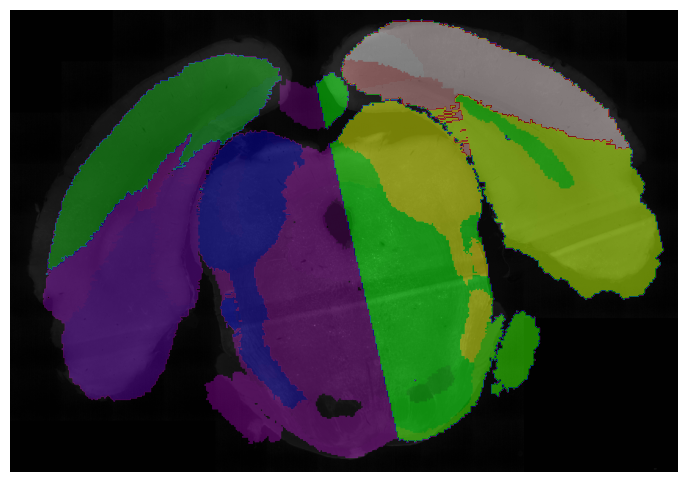

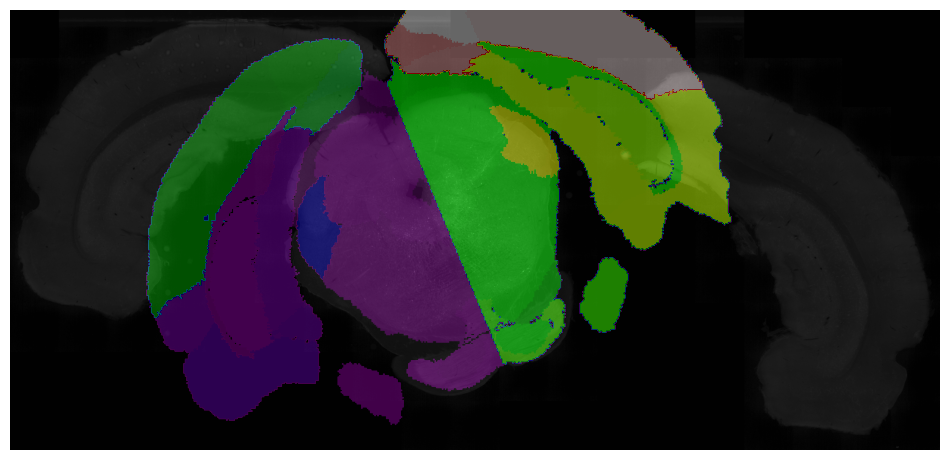

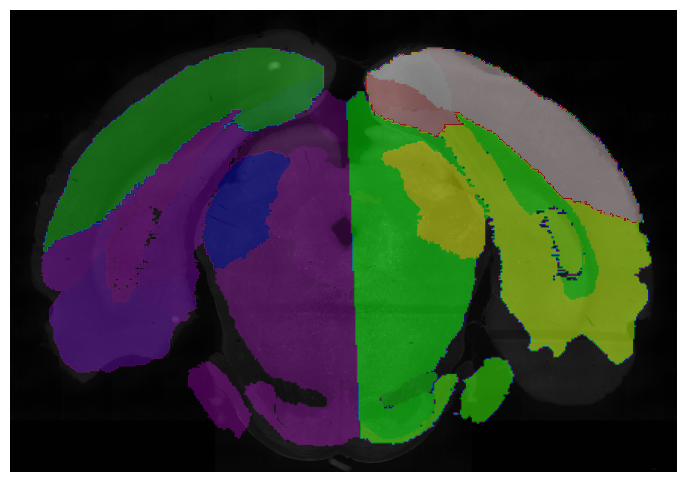

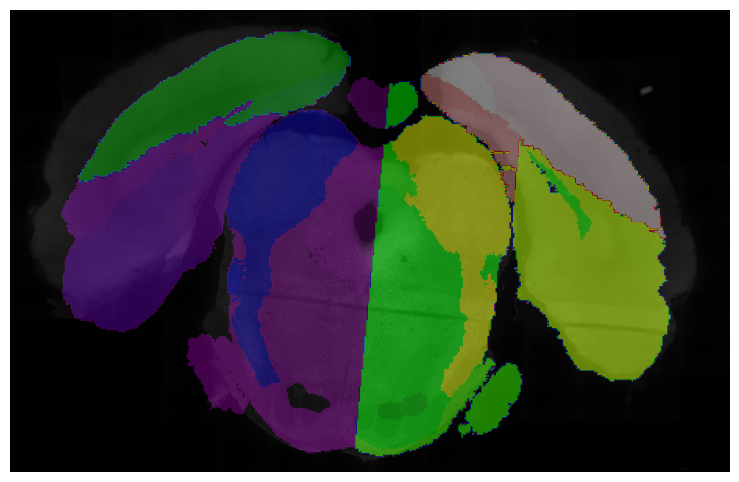

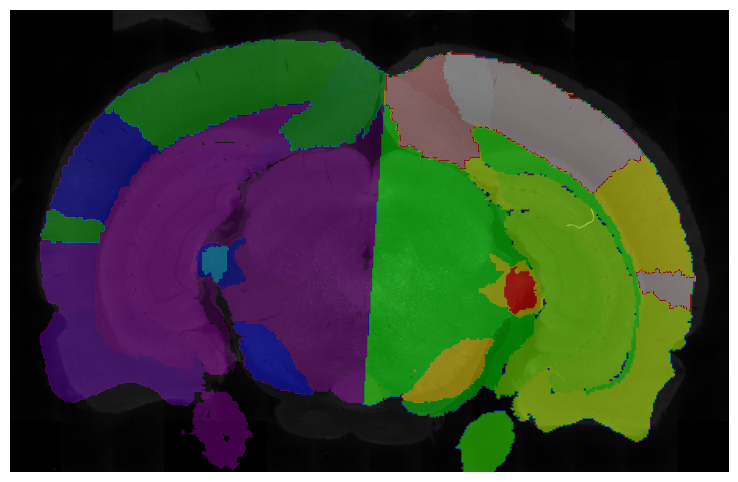

In [110]:
import os
import json
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
import glob
from PIL import Image

print(f"Processing subject: {curSubject }")
# Define the path to the JSON file
registration_json_path = f"../Downsampled_mCherry/{curSubject}/MyResults.json"

# Load the JSON data from the file
with open(registration_json_path, 'r') as file:
    registration_data = json.load(file)
    
# registration slices
registration_slices = registration_data.get("slices", [])

# Define image directories
image_png_dir = f"../Downsampled_mCherry/{curSubject}/"
imagePaths = glob.glob(os.path.join(image_png_dir, "*.tif")) + glob.glob(os.path.join(image_png_dir, "*.png"))
if len(registration_slices) != len(imagePaths):
    raise ValueError(f"Number of slices in JSON ({len(registration_slices)}) does not match number of images ({len(imagePaths)}) for subject {curSubject}.")
    # Create a folder for figures
    
for i, curSlice in enumerate(registration_slices[:5]):
    fileName = curSlice['filename']
    Oxyz = curSlice['anchoring'][:3]
    Uxyz = curSlice['anchoring'][3:6]
    Vxyz = curSlice['anchoring'][6:]
    
    # Load the histology image
    image_path = image_png_dir + fileName
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file {image_path} not found.")
    
    image_raw = io.imread(image_path)
    width, height = image_raw.shape[1], image_raw.shape[0]
    
    # Extract and upsample the downsampled atlas slice
    # atlas_slice = extract_section(downsampled_atlas, np.array(Oxyz)/np.array(downsample_factors),
    #                               np.array(Uxyz)/np.array(downsample_factors), 
    #                               np.array(Vxyz)/np.array(downsample_factors),
    #                               output_size=None)
    
    atlas_slice = extract_section(atlas_data, np.array(Oxyz),
                                  np.array(Uxyz), 
                                  np.array(Vxyz),
                                  output_size=None)
    atlas_slice_upsampled = upsample_and_pad_atlas_slice(atlas_slice, target_dims=(height, width))
    
    # Plot 
    plt.figure(figsize=(12, 6))
    plt.imshow(image_raw, cmap='gray')
    plt.imshow(atlas_slice_upsampled, cmap='nipy_spectral', alpha=0.5)
    plt.axis('off')
    plt.show()

In [92]:
def create_position_matrix(atlas_shape):
    """
    Create a 3D position matrix where each voxel contains its own coordinates.
    Using a single integer that encodes (x,y,z) position.
    """
    x_dim, y_dim, z_dim = atlas_shape
    
    # Create coordinate grids
    x_coords, y_coords, z_coords = np.meshgrid(
        np.arange(x_dim), 
        np.arange(y_dim), 
        np.arange(z_dim), 
        indexing='ij'
    )
    
    # Encode coordinates as a single integer: x + y*x_dim + z*x_dim*y_dim
    position_matrix = (x_coords + 
                      y_coords * x_dim + 
                      z_coords * x_dim * y_dim).astype(np.int64)
    
    return position_matrix

# Create the position matrix
position_matrix = create_position_matrix(atlas_data.shape)
print(f"Position matrix shape: {position_matrix.shape}")
print(f"Position matrix range: {position_matrix.min()} to {position_matrix.max()}")

Position matrix shape: (512, 1024, 512)
Position matrix range: 0 to 268435455


In [119]:
x, y, z = decode_position(position_matrix[300, 200, 141], position_matrix.shape[0], position_matrix.shape[1])
print(x, y, z)

300 200 141


In [113]:
def decode_position(encoded_pos, x_dim, y_dim):
    """Decode the encoded position back to (x, y, z) coordinates"""
    z = encoded_pos // (x_dim * y_dim)
    remainder = encoded_pos % (x_dim * y_dim)
    y = remainder // x_dim
    x = remainder % x_dim
    return x, y, z

In [ ]:


def create_cell_count_matrix(atlas_shape, all_positions, all_counts):
    """
    Create a 3D matrix with cell counts at each voxel position
    """
    import numpy as np
    cell_count_matrix = np.zeros(atlas_shape, dtype=np.float32)
    x_dim, y_dim, z_dim = atlas_shape
    
    for positions, counts in zip(all_positions, all_counts):
        for pos, count in zip(positions, counts):
            # Skip invalid positions (padding areas might have invalid values)
            if pos < 0 or pos >= x_dim * y_dim * z_dim:
                continue
                
            # Decode position
            x, y, z = decode_position(pos, x_dim, y_dim)
            
            # Ensure coordinates are within bounds
            if 0 <= x < x_dim and 0 <= y < y_dim and 0 <= z < z_dim:
                cell_count_matrix[x, y, z] += count
    
    return cell_count_matrix

In [270]:
def create_voxel_referred_matrix(all_positions_referred, atlas_shape):
    """
    Create a voxel-referred matrix from the list of all referred positions.
    """
    import numpy as np
    voxel_referred_matrix = np.zeros(atlas_shape, dtype=np.int64)
    for pos in all_positions_referred:
        
        # Decode position
        x, y, z = decode_position(pos, atlas_shape[0], atlas_shape[1])
        voxel_referred_matrix[x, y, z] = 1
    return voxel_referred_matrix

In [255]:
segmentation_data_path = "D:/Histology_analysis/NOSTIC_VTA_NA_dataset/mCherry_PNG/JW_NOSTIC_VTA15/JW_NOSTIC_VTA15_6-Region 3-channels_Simple Segmentation.h5"
import h5py
with h5py.File(segmentation_data_path, "r") as f:
    seg_data = f['exported_data'][:]
    attrs = dict(f.attrs)
    print(f.keys())
    
height, width = seg_data.shape[:2]

<KeysViewHDF5 ['exported_data']>


In [256]:
neuron_mask = (seg_data == 1)

In [257]:
registration_json_path = f"../Downsampled_mCherry/{curSubject}/MyResults.json"
with open(registration_json_path, 'r') as file:
    registration_data = json.load(file) 
registration_slices = registration_data.get("slices", [])

In [258]:
# Remove small objects (noise)
min_neuron_size = 10
from skimage.morphology import remove_small_objects
neuron_mask_filtered = remove_small_objects(neuron_mask, min_size=min_neuron_size)

In [259]:
for curSlice in registration_slices:
    if "JW_NOSTIC_VTA15_6-Region 4-channels" in curSlice['filename']:
        Oxyz = curSlice['anchoring'][:3]
        Uxyz = curSlice['anchoring'][3:6]
        Vxyz = curSlice['anchoring'][6:]
        print(f"O: {Oxyz}, U: {Uxyz}, V: {Vxyz}")
        break

O: [460.57213429865504, 447.38361332796046, 456.9228126762556], U: [-442.1286944099491, -5.921949327125959, -12.799067426536228], V: [11.439986239246991, -2.1014376053776687, -283.89099211216785]


In [260]:
# Label individual neuron objects
labeled_neurons = measure.label(neuron_mask_filtered, connectivity=2)  # 8-connectivity
num_neurons = labeled_neurons.max()
print(num_neurons)

431


In [261]:
# Extract position slice using the same method as atlas
position_slice = extract_section(position_matrix, np.array(Oxyz),
                                np.array(Uxyz), np.array(Vxyz),
                                output_size=None)

# Upsample position slice to match segmentation resolution
position_slice_upsampled = upsample_and_pad_atlas_slice(
    position_slice, target_dims=(height, width)
).astype(np.int64)

In [264]:
# For each neuron object, find which atlas position it belongs to
position_neuron_counts = {}

for neuron_id in range(1, num_neurons + 1):
    # Get mask for this specific neuron
    single_neuron_mask = (labeled_neurons == neuron_id)
    
    # Get all position values that this neuron covers
    neuron_positions = position_slice_upsampled[single_neuron_mask.squeeze()]
    
    # Find the most common position (majority vote for this neuron)
    unique_positions, counts = np.unique(neuron_positions, return_counts=True)
    most_common_position = unique_positions[np.argmax(counts)]
    
    # Count this neuron in the corresponding atlas position
    if most_common_position in position_neuron_counts:
        position_neuron_counts[most_common_position] += 1
    else:
        position_neuron_counts[most_common_position] = 1

# Convert to arrays for consistency with previous function
unique_positions = np.array(list(position_neuron_counts.keys()))
neuron_counts = np.array(list(position_neuron_counts.values()))

In [268]:
from skimage import measure
from scipy import ndimage

def process_slice_with_neuron_object_counting(curSlice, position_matrix, atlas_data, segmentation_data, min_neuron_size=10):
    """
    Process one slice: extract position info, count neuron objects (not pixels), map back to 3D
    """
    fileName = curSlice['filename']
    Oxyz = curSlice['anchoring'][:3]
    Uxyz = curSlice['anchoring'][3:6]
    Vxyz = curSlice['anchoring'][6:]
    
    # Load segmentation data for this slice
    seg_data = segmentation_data  # Your segmentation mask (neurons = 1)
    height, width = seg_data.shape[:2]
    
    # Extract position slice using the same method as atlas
    position_slice = extract_section(position_matrix, np.array(Oxyz),
                                   np.array(Uxyz), np.array(Vxyz),
                                   output_size=None)
    
    # Reference voxels, we need to track what voxels in the position matrix has been used
    # So that we cancreate a reference matrix with 0 and 1 that shows what voxels are observed.
    position_ref = position_slice.flatten()
    
    # Upsample position slice to match segmentation resolution
    position_slice_upsampled = upsample_and_pad_atlas_slice(
        position_slice, target_dims=(height, width)
    ).astype(np.int64)
    
    # Extract neurons and filter small objects
    neuron_mask = (seg_data == 1)
    
    # Remove small objects (noise)
    from skimage.morphology import remove_small_objects
    neuron_mask_filtered = remove_small_objects(neuron_mask, min_size=min_neuron_size)
    
    # Label individual neuron objects
    labeled_neurons = measure.label(neuron_mask_filtered, connectivity=2)  # 8-connectivity
    num_neurons = labeled_neurons.max()
    
    print(f"Found {num_neurons} neuron objects in {fileName}")
    
    # For each neuron object, find which atlas position it belongs to
    position_neuron_counts = {}
    
    for neuron_id in range(1, num_neurons + 1):
        # Get mask for this specific neuron
        single_neuron_mask = (labeled_neurons == neuron_id)
        
        # Get all position values that this neuron covers
        neuron_positions = position_slice_upsampled[single_neuron_mask.squeeze()]
        
        # Find the most common position (majority vote for this neuron)
        unique_positions, counts = np.unique(neuron_positions, return_counts=True)
        most_common_position = unique_positions[np.argmax(counts)]
        
        # Count this neuron in the corresponding atlas position
        if most_common_position in position_neuron_counts:
            position_neuron_counts[most_common_position] += 1
        else:
            position_neuron_counts[most_common_position] = 1
    
    # Convert to arrays for consistency with previous function
    unique_positions = np.array(list(position_neuron_counts.keys()))
    neuron_counts = np.array(list(position_neuron_counts.values()))

    return unique_positions, neuron_counts, position_ref, position_slice_upsampled.shape, labeled_neurons

# Alternative approach: Assign neurons based on their centroid
def process_slice_with_centroid_assignment(curSlice, position_matrix, atlas_data, segmentation_data, min_neuron_size=10):
    """
    Alternative: Assign each neuron to atlas position based on its centroid
    """
    fileName = curSlice['filename']
    Oxyz = curSlice['anchoring'][:3]
    Uxyz = curSlice['anchoring'][3:6]
    Vxyz = curSlice['anchoring'][6:]
    
    seg_data = segmentation_data
    height, width = seg_data.shape[:2]
    
    # Extract and upsample position slice
    position_slice = extract_section(position_matrix, np.array(Oxyz),
                                   np.array(Uxyz), np.array(Vxyz),
                                   output_size=None)
    position_slice_upsampled = upsample_and_pad_atlas_slice(
        position_slice, target_dims=(height, width)
    ).astype(np.int64)
    
    # Extract and label neurons
    neuron_mask = (seg_data == 1)
    from skimage.morphology import remove_small_objects
    neuron_mask_filtered = remove_small_objects(neuron_mask, min_size=min_neuron_size)
    labeled_neurons = measure.label(neuron_mask_filtered, connectivity=2)
    
    # Get properties of each neuron
    props = measure.regionprops(labeled_neurons)
    
    position_neuron_counts = {}
    
    for prop in props:
        # Get centroid coordinates (row, col)
        centroid_y, centroid_x = prop.centroid
        centroid_y, centroid_x = int(round(centroid_y)), int(round(centroid_x))
        
        # Ensure centroid is within bounds
        centroid_y = max(0, min(centroid_y, height - 1))
        centroid_x = max(0, min(centroid_x, width - 1))
        
        # Get the atlas position at the centroid
        atlas_position = position_slice_upsampled[centroid_y, centroid_x]
        
        # Count this neuron
        if atlas_position in position_neuron_counts:
            position_neuron_counts[atlas_position] += 1
        else:
            position_neuron_counts[atlas_position] = 1
    
    unique_positions = np.array(list(position_neuron_counts.keys()))
    neuron_counts = np.array(list(position_neuron_counts.values()))
    
    print(f"Found {len(props)} neuron objects in {fileName} (centroid method)")
    
    return unique_positions, neuron_counts, position_slice_upsampled.shape, labeled_neurons

In [277]:
def process_all_slices_with_neuron_objects(curSubject, atlas_data, position_matrix, method='majority_vote'):
    """
    Process all slices for a subject and create cell count matrix using neuron object counting
    
    Parameters:
    method: 'majority_vote' or 'centroid'
    """
    import h5py
    
    # Load registration data
    registration_json_path = f"../Downsampled_mCherry/{curSubject}/MyResults.json"
    with open(registration_json_path, 'r') as file:
        registration_data = json.load(file)
    registration_slices = registration_data.get("slices", [])
    
    all_positions_neuron = []
    all_positions_referred = []
    all_counts = []
    total_neurons = 0
    
    for i, curSlice in enumerate(registration_slices):
        print(f"Processing slice {i+1}/{len(registration_slices)}: {curSlice['filename']}")
        
        # Load segmentation data for this slice
        slice_name = curSlice['filename'].replace('.png', '')
        h5_path = f"../mCherry_PNG/{curSubject}/{slice_name}_Simple Segmentation.h5"
        
        if os.path.exists(h5_path):
            with h5py.File(h5_path, "r") as f:
                seg_data = f['exported_data'][:]
        else:
            print(f"Segmentation file not found: {h5_path}")
            continue
        
        # Process this slice with neuron object counting
        if method == 'majority_vote':
            positions, counts, position_ref, slice_shape, labeled_neurons = process_slice_with_neuron_object_counting(
                curSlice, position_matrix, atlas_data, seg_data, min_neuron_size=10
            )
        elif method == 'centroid':
            positions, counts, position_ref, slice_shape, labeled_neurons = process_slice_with_centroid_assignment(
                curSlice, position_matrix, atlas_data, seg_data, min_neuron_size=10
            )

        all_positions_neuron.append(positions)
        all_positions_referred.append(position_ref)
        all_counts.append(counts)
        total_neurons += counts.sum()
        
        print(f"  -> {counts.sum()} neurons assigned to {len(positions)} atlas positions")
    
    # Create cell count matrix
    cell_count_matrix = create_cell_count_matrix(atlas_data.shape, all_positions_neuron, all_counts)
    
    # Create voxel-referred matrix
    voxel_referred_matrix = create_voxel_referred_matrix(all_positions_referred, atlas_data.shape)

    print(f"\nSummary for {curSubject}:")
    print(f"Total neurons counted: {total_neurons}")
    print(f"Total neurons in matrix: {cell_count_matrix.sum()}")
    print(f"Non-zero voxels: {np.count_nonzero(cell_count_matrix)}")
    
    return cell_count_matrix, voxel_referred_matrix, all_positions_neuron, all_counts

# Run the processing with neuron object counting
cell_count_matrix, voxel_referred_matrix, all_positions_neuron, all_counts = process_all_slices_with_neuron_objects(
    curSubject, atlas_data, position_matrix, method='majority_vote'  # 'centroid' or 'majority_vote'
)

Processing slice 1/30: JW_NOSTIC_VTA15_7-Region 001-channels.png
Found 241 neuron objects in JW_NOSTIC_VTA15_7-Region 001-channels.png
  -> 241 neurons assigned to 239 atlas positions
Processing slice 2/30: JW_NOSTIC_VTA15_6-Region 3-channels.png
Found 431 neuron objects in JW_NOSTIC_VTA15_6-Region 3-channels.png
  -> 431 neurons assigned to 423 atlas positions
Processing slice 3/30: JW_NOSTIC_VTA15_6-Region 4-channels.png
Found 283 neuron objects in JW_NOSTIC_VTA15_6-Region 4-channels.png
  -> 283 neurons assigned to 282 atlas positions
Processing slice 4/30: JW_NOSTIC_VTA15_7-Region 002-channels.png
Found 214 neuron objects in JW_NOSTIC_VTA15_7-Region 002-channels.png
  -> 214 neurons assigned to 213 atlas positions
Processing slice 5/30: JW_NOSTIC_VTA15_6-Region 2-channels.png
Found 456 neuron objects in JW_NOSTIC_VTA15_6-Region 2-channels.png
  -> 456 neurons assigned to 449 atlas positions
Processing slice 6/30: JW_NOSTIC_VTA15_6-Region 1-channels.png
Found 592 neuron objects in J

# Downsample the cell count matrix (sum) and voxel referred matrix (mean)

In [320]:
# Now downsample both atlas and cell count matrix with the same method
def downsample_matrices(atlas_data, cell_count_matrix, voxel_referred_matrix, downsample_factors):
    """
    Downsample both atlas and cell count matrix using consistent methods
    """
    from scipy.ndimage import zoom
    
    zoom_factors = [1.0 / factor for factor in tuple(map(int, downsample_factors))]
    
    # Downsample atlas (nearest neighbor to preserve labels)
    downsampled_atlas = zoom(atlas_data, zoom_factors, order=0)
    
    # Downsample cell counts (sum to preserve total count)
    # Use order=1 (linear) then round, or use block_reduce with sum
    from skimage.measure import block_reduce
    

    
    downsampled_cells = block_reduce(cell_count_matrix, 
                                   block_size=tuple(map(int, downsample_factors)),
                                   func=np.sum)
    
    downsampled_ref = block_reduce(voxel_referred_matrix, 
                                   block_size=tuple(map(int, downsample_factors)),
                                   func=np.mean)

    # Check if they have the same shape
    if downsampled_cells.shape != downsampled_atlas.shape:
        print("Warning: Downsampled atlas and cell counts matrices have different shapes.")
        print(f"  Atlas shape: {downsampled_atlas.shape}")
        print(f"  Cell counts shape: {downsampled_cells.shape}")

    return downsampled_atlas, downsampled_cells, downsampled_ref


# Downsample both
downsampled_atlas, downsampled_cell_counts, downsampled_voxel_ref = downsample_matrices(
    atlas_data, cell_count_matrix, voxel_referred_matrix, downsample_factors
)

print(f"Downsampled atlas shape: {downsampled_atlas.shape}")
print(f"Downsampled cell counts shape: {downsampled_cell_counts.shape}")
print(f"Downsampled voxel referred shape: {downsampled_voxel_ref.shape}")
print(f"Total neurons preserved: {downsampled_cell_counts.sum()}")

Downsampled atlas shape: (43, 41, 43)
Downsampled cell counts shape: (43, 41, 43)
Downsampled voxel referred shape: (43, 41, 43)
Total neurons preserved: 9440.0


# Post downsampling processing

In [322]:
# Delete the voxels with minor cell counts
minor_cell_count = 5
downsampled_cell_counts[downsampled_cell_counts < minor_cell_count] = 0

In [323]:
# Step 1: Normalize cell counts by coverage to estimate true counts
coverage_threshold = 0.02  # Minimum 10% coverage required
normalized_cell_counts = np.where(
    downsampled_voxel_ref >= coverage_threshold,
    downsampled_cell_counts / downsampled_voxel_ref,  # Divide by coverage
    0
)

# Step 2: Calculate actual density using fMRI voxel size
voxel_volume_mm3 = np.prod(target_voxel_size_mm)  # [0.5, 1.0, 0.5] = 0.25 mm³
cell_density_matrix = normalized_cell_counts / voxel_volume_mm3

print(f"Voxel volume: {voxel_volume_mm3} mm³")
print(f"Coverage threshold: {coverage_threshold}")
print(f"Voxels with reliable data: {np.sum(downsampled_voxel_ref >= coverage_threshold)}")
print(f"Max normalized density: {cell_density_matrix.max():.2f} cells/mm³")

Voxel volume: 0.25 mm³
Coverage threshold: 0.02
Voxels with reliable data: 11534
Max normalized density: 5689.51 cells/mm³


C:\Users\Wenji\AppData\Local\Temp\ipykernel_1692\3482803552.py:5: RuntimeWarning: divide by zero encountered in divide
  downsampled_cell_counts / downsampled_voxel_ref,  # Divide by coverage
C:\Users\Wenji\AppData\Local\Temp\ipykernel_1692\3482803552.py:5: RuntimeWarning: invalid value encountered in divide
  downsampled_cell_counts / downsampled_voxel_ref,  # Divide by coverage


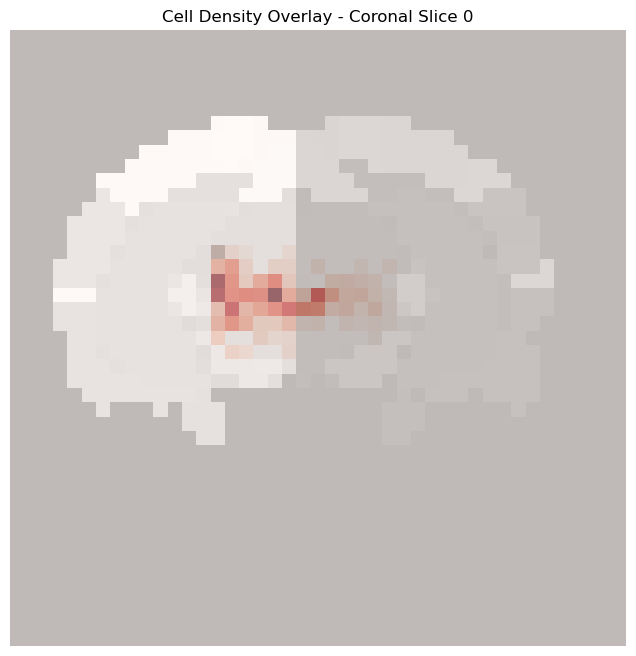

In [346]:
# Plot the animation of cell_density_matrix overlay with downsampled atlas
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

# Initialize the images
atlas_img = ax.imshow(np.rot90(downsampled_atlas[:, 19, :]), cmap='gray', alpha=0.5)
density_img = ax.imshow(np.rot90(cell_density_matrix[:, 19, :]), cmap='Reds', alpha=0.5, interpolation='nearest')
ax.set_title('Cell Density Overlay - Coronal Slice 0')
ax.axis('off')
plt.show()

In [347]:
a = np.array([[1,2,3], [4,5,0], [0,0,0]])
density_masked = np.ma.masked_where(a == 0, a)

In [348]:
density_masked

masked_array(
  data=[[1, 2, 3],
        [4, 5, --],
        [--, --, --]],
  mask=[[False, False, False],
        [False, False,  True],
        [ True,  True,  True]],
  fill_value=999999)

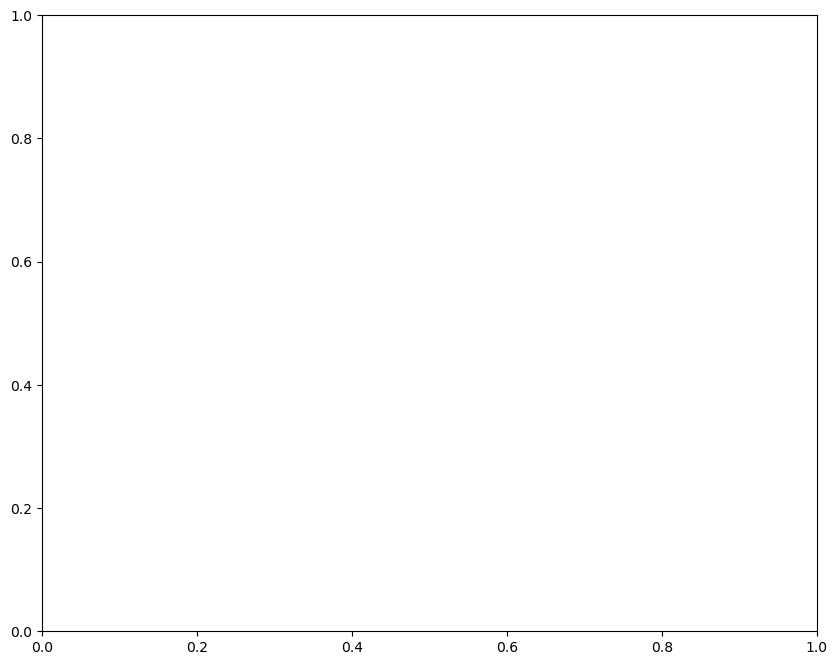

In [349]:
def animate_density_overlay(frame):
    ax.clear()
    # Show atlas in grayscale
    ax.imshow(np.rot90(downsampled_atlas[:, frame, :]), cmap='gray', alpha=0.7)
    # Overlay cell density in red
    density_slice = np.rot90(cell_density_matrix[:, frame, :])
    # Only show non-zero density values
    density_masked = np.ma.masked_where(density_slice == 0, density_slice)
    ax.imshow(density_masked, cmap='Reds', alpha=0.8, interpolation='nearest')
    ax.set_title(f'Cell Density Overlay - Coronal Slice {frame}')
    ax.axis('off')

# Create animation
fig, ax = plt.subplots(figsize=(10, 8))
ani = FuncAnimation(fig, animate_density_overlay, frames=cell_density_matrix.shape[1], 
                   interval=200, repeat=True)

plt.show()

# Save animation
ani.save('cell_density_overlay_animation.mp4', writer='ffmpeg', fps=5)

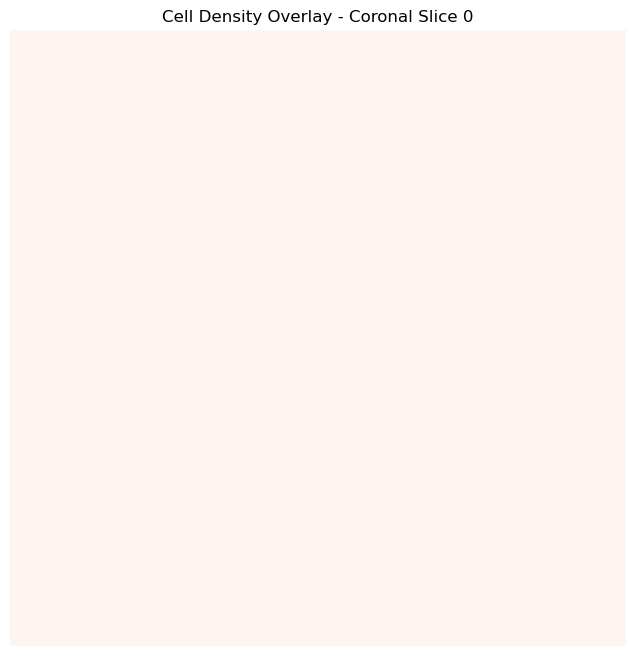

In [336]:
# Plot the animation of cell_density_matrix overlay with downsampled atlas
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

# Initialize the images
atlas_img = ax.imshow(np.rot90(downsampled_atlas[:, 15, :]), cmap='gray', alpha=0.5)
density_img = ax.imshow(np.rot90(cell_density_matrix[:, 15, :]), cmap='Reds', alpha=1, interpolation='nearest')
ax.set_title('Cell Density Overlay - Coronal Slice 0')
ax.axis('off')
plt.show()

def update(frame):
    # Update the data for both images
    atlas_img.set_array(np.rot90(downsampled_atlas[:, frame, :]))
    density_img.set_array(np.rot90(cell_density_matrix[:, frame, :]))
    ax.set_title(f'Cell Density Overlay - Coronal Slice {frame}')
    return [atlas_img, density_img]

ani = FuncAnimation(fig, update, frames=cell_density_matrix.shape[1], blit=True, interval=200)


ani.save('cell_density.mp4', writer='ffmpeg', fps=5)

=== Cell Count Matrix Analysis ===
Shape: (43, 41, 43)
Data type: float32
Total cells: 7862.0
Non-zero voxels: 454
Max cells per voxel: 145.0
Mean cells per non-zero voxel: 17.32

Cell count distribution:
  0 cells: 75355 voxels
  5 cells: 46 voxels
  6 cells: 37 voxels
  7 cells: 45 voxels
  8 cells: 32 voxels
  9 cells: 22 voxels
  10 cells: 31 voxels
  11 cells: 19 voxels
  12 cells: 17 voxels
  13 cells: 12 voxels

=== Voxel Reference Matrix Analysis ===
Shape: (43, 41, 43)
Data type: float64
Non-zero voxels: 12253
Max reference value: 0.16
Min reference value: 0.0

Reference value distribution:
  0.000: 63556 voxels
  0.000: 10 voxels
  0.001: 11 voxels
  0.001: 12 voxels
  0.001: 11 voxels
  0.001: 13 voxels
  0.002: 11 voxels
  0.002: 5 voxels
  0.002: 12 voxels
  0.003: 7 voxels
  0.003: 9 voxels
  0.003: 14 voxels
  0.003: 56 voxels
  0.004: 6 voxels
  0.004: 11 voxels
  0.004: 10 voxels
  0.004: 5 voxels
  0.005: 4 voxels
  0.005: 8 voxels
  0.005: 7 voxels
  0.006: 7 voxels


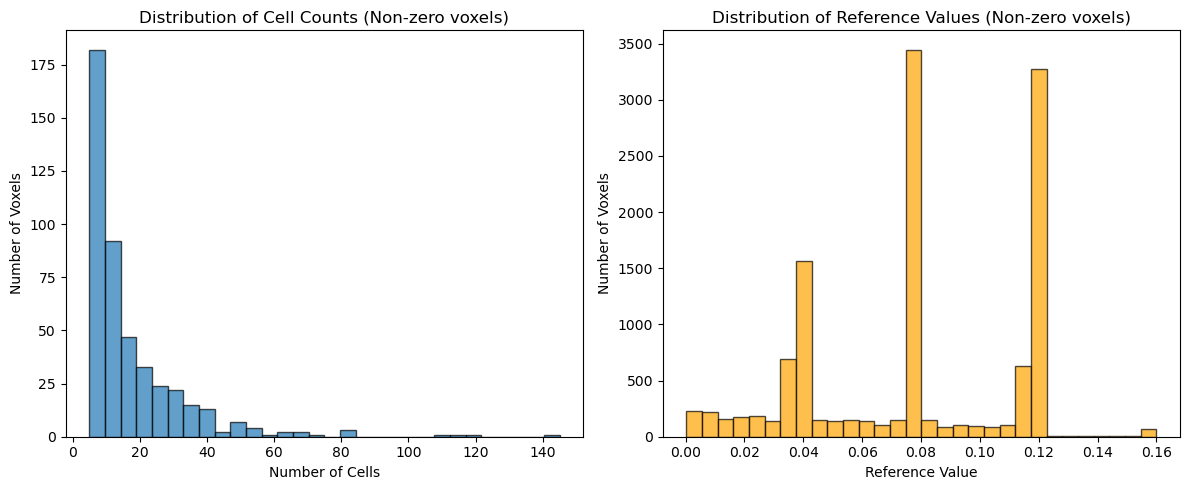

In [324]:
# Analyze the distribution of values in both matrices
print("=== Cell Count Matrix Analysis ===")
print(f"Shape: {downsampled_cell_counts.shape}")
print(f"Data type: {downsampled_cell_counts.dtype}")
print(f"Total cells: {downsampled_cell_counts.sum()}")
print(f"Non-zero voxels: {np.count_nonzero(downsampled_cell_counts)}")
print(f"Max cells per voxel: {downsampled_cell_counts.max()}")
print(f"Mean cells per non-zero voxel: {downsampled_cell_counts[downsampled_cell_counts > 0].mean():.2f}")

# Get histogram of cell counts
unique_counts, count_freq = np.unique(downsampled_cell_counts, return_counts=True)
print("\nCell count distribution:")
for count, freq in zip(unique_counts[:10], count_freq[:10]):  # Show first 10
    print(f"  {int(count)} cells: {freq} voxels")

print("\n=== Voxel Reference Matrix Analysis ===")
print(f"Shape: {downsampled_voxel_ref.shape}")
print(f"Data type: {downsampled_voxel_ref.dtype}")
print(f"Non-zero voxels: {np.count_nonzero(downsampled_voxel_ref)}")
print(f"Max reference value: {downsampled_voxel_ref.max()}")
print(f"Min reference value: {downsampled_voxel_ref.min()}")

# Check reference value distribution
unique_refs, ref_freq = np.unique(downsampled_voxel_ref, return_counts=True)
print(f"\nReference value distribution:")
for ref, freq in zip(unique_refs, ref_freq):
    print(f"  {ref:.3f}: {freq} voxels")

print("\n=== Cell Density Matrix Analysis ===")
print(f"Shape: {cell_density_matrix.shape}")
print(f"Non-zero voxels: {np.count_nonzero(cell_density_matrix)}")
print(f"Max density: {cell_density_matrix.max()}")
print(f"Total weighted cells: {cell_density_matrix.sum()}")

# Create visualization of the distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Cell count histogram
non_zero_counts = downsampled_cell_counts[downsampled_cell_counts > 0]
axes[0].hist(non_zero_counts, bins=30, alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of Cell Counts (Non-zero voxels)')
axes[0].set_xlabel('Number of Cells')
axes[0].set_ylabel('Number of Voxels')

# Plot 2: Reference value histogram
non_zero_refs = downsampled_voxel_ref[downsampled_voxel_ref > 0]
axes[1].hist(non_zero_refs, bins=30, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title('Distribution of Reference Values (Non-zero voxels)')
axes[1].set_xlabel('Reference Value')
axes[1].set_ylabel('Number of Voxels')

plt.tight_layout()
plt.show()


In [300]:
cell_density_matrix.shape

(43, 41, 43)

In [280]:
downsample_factors

[12.820512820512821, 25.641025641025642, 12.820512820512821]

In [103]:
a = np.array([1,2,1,1,2,2,2,2,1])
b = np.arange(1, len(a)+1)
neuron_mask = (a == 1)
neuron_positions = b[neuron_mask]
unique_positions, counts = np.unique(neuron_positions, return_counts=True)


In [105]:
counts

array([1, 1, 1, 1], dtype=int64)

In [102]:
neuron_positions

array([1, 3, 4, 9])

In [ ]:
# Option 1: If you want a complex number (only i and j components)
a = 1j + 2  # Note: j is the imaginary unit in Python, i is not valid

# Option 2: If you want to create a 3D vector as a list
a = [1, 2, 3]

# Option 3: If you want to create a numpy array for 3D vector
a = np.array([1, 2, 3])

# Option 4: If you want quaternion-like behavior, use a tuple or custom class
a = (1, 2, 3, 0)  # (i, j, k, real) components

SyntaxError: invalid syntax (38799999.py, line 1)

In [91]:
atlas_data.shape

(512, 1024, 512)

In [81]:
len(registration_slices)

30

In [ ]:
subject_names = []

5

In [15]:
atlas_int = atlas_data.astype(np.int32)

In [21]:
downsampled_atlas??

Type:        int32
String form: 0
File:        c:\users\wenji\miniconda3\envs\deepslice-3.9\lib\site-packages\numpy\__init__.py
Docstring:  
Signed integer type, compatible with Python `int` and C ``long``.

:Character code: ``'l'``
:Canonical name: `numpy.int_`
:Alias on this platform (win32 AMD64): `numpy.int32`: 32-bit signed integer (``-2_147_483_648`` to ``2_147_483_647``).